# ValueInvestor Project

## Background:


We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.


Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.


## Data Description:


You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged.


In [1]:
# ingore warnings
import warnings
warnings.filterwarnings('ignore')

# cell output clear tool
from IPython.display import clear_output

# data
import pandas as pd
import numpy as np

# visualisations
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.utils import plot_model

# date
from datetime import datetime
import matplotlib.dates as md

In [2]:
# mount google drive
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/00_Infos/Nicholas/Work/02 Apziva/L5/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data and Data Preprocessing

In [3]:
os.listdir()

['2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv',
 '2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv',
 '2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv',
 '2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv',
 '2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv',
 '2020Q1Q2Q3Q4-2021Q1 - Colombia - Cementos Argos SA (CCB).csv',
 '2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv',
 '2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv',
 'model.png']

In [4]:
# load dataset
data = pd.read_csv("2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv")
original_data = data.copy()
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",291.02,294,294.42,290.26,47.00M,-0.76%
1,"Mar 30, 2021",293.25,294.86,295.72,291.5,38.81M,-0.02%
2,"Mar 29, 2021",293.3,289.72,294.09,289.26,43.68M,0.71%
3,"Mar 26, 2021",291.22,288.63,292.75,288.32,56.07M,1.59%
4,"Mar 25, 2021",286.66,286.5,287.03,283.85,35.22M,0.30%


In [5]:
# get info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      312 non-null    object
 1   Price     312 non-null    object
 2   Open      312 non-null    object
 3   High      312 non-null    object
 4   Low       312 non-null    object
 5   Vol.      311 non-null    object
 6   Change %  311 non-null    object
dtypes: object(7)
memory usage: 17.2+ KB


In [6]:
# see if there are duplicates rows in the data
sum(data.duplicated())

0

In [7]:
# drop unnecessary columns
data.drop(['Vol.', 'Change %'], axis=1, inplace=True)

# Eliminate last row with summary data
data = data.head(data.shape[0]-1)

# Convert Date to datetime format and organize by date
data['Date'] = data['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y"))
data = data.sort_values('Date')

# Change Price dtype to float
data[['Price', 'Low', 'High', 'Open']] = data[['Price', 'Low', 'High', 'Open']].astype("float32")

# Reset index and set date as index
data.reset_index(drop=True, inplace=True)
data['Date'] = pd.to_datetime(data.Date)
data = data.set_index('Date')
data.sort_index(inplace=True)

data.head(10)

,Price,Open,High,Low
Date,,,,
2020-01-03,255.000000,255.990005,258.190002,253.699997
2020-01-06,253.899994,254.750000,254.839996,251.399994
2020-01-08,259.149994,253.570007,259.149994,253.029999
2020-01-09,257.989990,259.399994,261.760010,257.010010
2020-01-10,258.190002,257.859985,259.250000,256.880005
2020-01-13,262.399994,258.299988,262.399994,257.149994
2020-01-14,259.049988,262.500000,263.220001,258.619995
2020-01-15,256.309998,258.489990,258.910004,254.210007
2020-01-16,257.510010,257.109985,259.510010,256.100006


In [8]:
# function that plot the time series
def plot_time_series(timeseries: pd.DataFrame, y: list=[], labels: list=[], colors: list=[]):

    sns.set()
    fig, ax = plt.subplots(1, 1, figsize = (20,6))

    for i in range(len(y)):
        ax.plot(timeseries.index.values, timeseries[y[i]], label=labels[i], color=colors[i])

    ax.xaxis.set_major_locator(md.MonthLocator())
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
    ax.set_ylabel('Stock price')
    ax.set_xlabel('Date')
    ax.tick_params(labelrotation=45)
    ax.legend()
    plt.show()

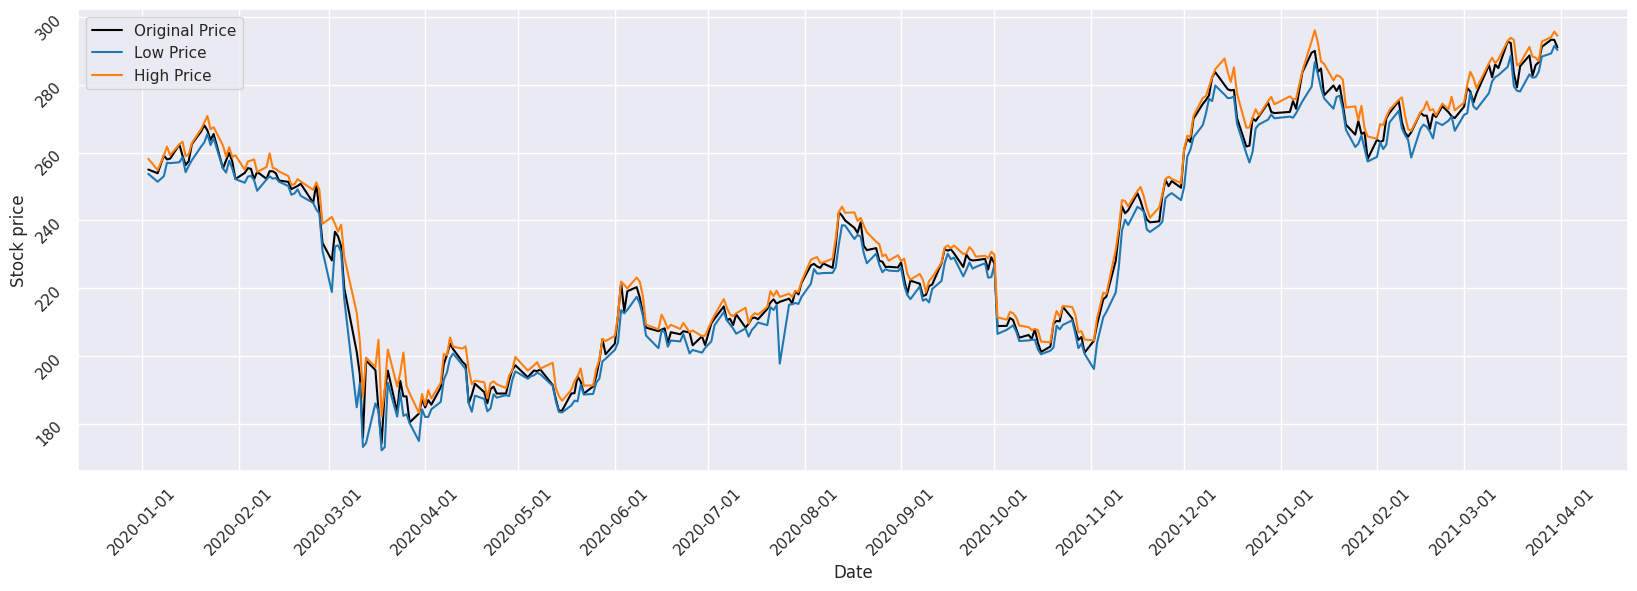

In [9]:
plot_time_series(data, y=['Price', 'Low', 'High'],
                       labels=['Original Price', 'Low Price', 'High Price'],
                       colors=['black', 'tab:blue', 'tab:orange'])

* We will use LTSM as our model, so we don't need to make our time-series stationary since LTSM can learn from non-linear or non-sationary time-series.

* We will normalize the feature we are gonna use to train our model ,though, to help it.

### Setting target variable and selected features

In [10]:
target_y = data['Price']
X_feat = data.iloc[:, 2:5]

### Scaling

In [11]:
sc= StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns,
                    data=X_ft,
                    index=X_feat.index)

print(X_ft.head())

                High       Low
Date                          
2020-01-03  0.651862  0.697388
2020-01-06  0.547253  0.625569
2020-01-08  0.681839  0.676467
2020-01-09  0.763341  0.800745
2020-01-10  0.684962  0.796686


### Create training set, test set and processing data for LSTM

The function below takes the entire data and creates windows of size n_steps starting from the beginning. The target y will contain the target value corresponding to the n_steps’th index. So if n_steps is 10, the first element in X will have features from 10 data samples, and y will contain the target of the 10th data sample.

In [12]:
def lstm_split(data, n_steps):
  X,y = [], []
  for i in range(len(data)-n_steps+1):
    X.append(data[i:i + n_steps, :-1])
    y.append(data[i + n_steps-1, -1])

  return np.array(X), np.array(y)

In [13]:
# Splitting to Training set and Test set
X1, y1 = lstm_split(X_ft.values, n_steps=2)

train_split = 0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = X_ft.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(310, 2, 1) (248, 2, 1) (62, 2, 1) (62,)


We must divide the entire dataset into training and test sets before feeding it into the training model. The Machine Learning LSTM model will be trained on the data in the training set and tested for accuracy and backpropagation on the test set.

The sci-kit-learn library’s TimeSeriesSplit class will be used for this. We set the number of splits to 2, indicating that 20% of the data will be used as the test set and 80% of the data will be used to train the LSTM model. The advantage of utilizing this Time Series split is that the split time series data samples are examined at regular time intervals

### Building the model - Base

In [14]:
# Building the LSTM Model - Base
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]),
              activation='relu', return_sequences=True))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 32)             4352      
                                                                 
 dense (Dense)               (None, 2, 1)              33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Model Training
history=lstm.fit(X_train, y_train,
                 epochs=100, batch_size=4,
                 verbose=2, shuffle=False)

Epoch 1/100
62/62 - 6s - loss: 0.7524 - 6s/epoch - 90ms/step
Epoch 2/100
62/62 - 0s - loss: 0.5755 - 429ms/epoch - 7ms/step
Epoch 3/100
62/62 - 0s - loss: 0.3899 - 421ms/epoch - 7ms/step
Epoch 4/100
62/62 - 0s - loss: 0.2355 - 422ms/epoch - 7ms/step
Epoch 5/100
62/62 - 0s - loss: 0.1714 - 346ms/epoch - 6ms/step
Epoch 6/100
62/62 - 0s - loss: 0.1521 - 403ms/epoch - 6ms/step
Epoch 7/100
62/62 - 0s - loss: 0.1347 - 421ms/epoch - 7ms/step
Epoch 8/100
62/62 - 0s - loss: 0.1158 - 376ms/epoch - 6ms/step
Epoch 9/100
62/62 - 0s - loss: 0.0972 - 373ms/epoch - 6ms/step
Epoch 10/100
62/62 - 0s - loss: 0.0807 - 350ms/epoch - 6ms/step
Epoch 11/100
62/62 - 0s - loss: 0.0676 - 381ms/epoch - 6ms/step
Epoch 12/100
62/62 - 1s - loss: 0.0584 - 506ms/epoch - 8ms/step
Epoch 13/100
62/62 - 0s - loss: 0.0527 - 387ms/epoch - 6ms/step
Epoch 14/100
62/62 - 0s - loss: 0.0494 - 390ms/epoch - 6ms/step
Epoch 15/100
62/62 - 0s - loss: 0.0477 - 391ms/epoch - 6ms/step
Epoch 16/100
62/62 - 1s - loss: 0.0469 - 659ms/epoc

### Prediction and Evaluation

In [16]:
# LSTM Prediction
y_pred= lstm.predict(X_test)

2/2 [==============================] - 0s 7ms/step


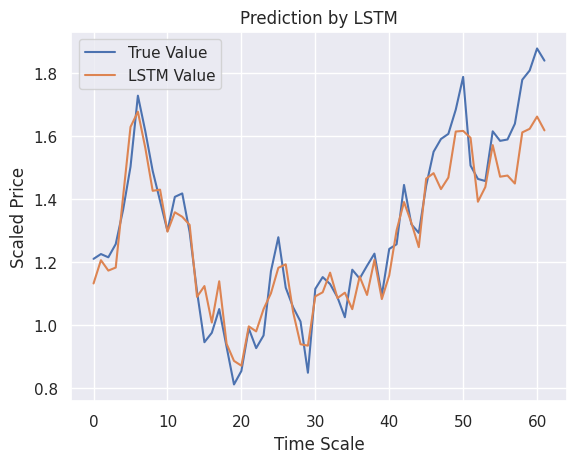

In [17]:
# Predicted vs True Price Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred[:,-1,:], label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

In [18]:
rmse = mean_squared_error(y_test, y_pred[:,-1,:], squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred[:,-1,:])
print('RSME: ', rmse)
print('MAPE: ', mape)

RSME:  0.090502106
MAPE:  0.053211085


### Building the model - Deeper

In [24]:
# Building the LSTM Model - Deeper
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]),
              activation='relu', return_sequences=True))
lstm.add(LSTM(32, activation='relu'))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 2, 50)             10400     
                                                                 
 lstm_4 (LSTM)               (None, 32)                10624     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Model Training
history=lstm.fit(X_train, y_train,
                 epochs=100, batch_size=4,
                 verbose=2, shuffle=False)

Epoch 1/100
62/62 - 7s - loss: 0.7628 - 7s/epoch - 112ms/step
Epoch 2/100
62/62 - 1s - loss: 0.4946 - 587ms/epoch - 9ms/step
Epoch 3/100
62/62 - 0s - loss: 0.1519 - 458ms/epoch - 7ms/step
Epoch 4/100
62/62 - 0s - loss: 0.0526 - 380ms/epoch - 6ms/step
Epoch 5/100
62/62 - 0s - loss: 0.0265 - 366ms/epoch - 6ms/step
Epoch 6/100
62/62 - 0s - loss: 0.0292 - 368ms/epoch - 6ms/step
Epoch 7/100
62/62 - 0s - loss: 0.0325 - 401ms/epoch - 6ms/step
Epoch 8/100
62/62 - 0s - loss: 0.0317 - 391ms/epoch - 6ms/step
Epoch 9/100
62/62 - 0s - loss: 0.0327 - 367ms/epoch - 6ms/step
Epoch 10/100
62/62 - 0s - loss: 0.0312 - 405ms/epoch - 7ms/step
Epoch 11/100
62/62 - 0s - loss: 0.0318 - 378ms/epoch - 6ms/step
Epoch 12/100
62/62 - 0s - loss: 0.0306 - 380ms/epoch - 6ms/step
Epoch 13/100
62/62 - 0s - loss: 0.0308 - 378ms/epoch - 6ms/step
Epoch 14/100
62/62 - 0s - loss: 0.0302 - 368ms/epoch - 6ms/step
Epoch 15/100
62/62 - 0s - loss: 0.0301 - 385ms/epoch - 6ms/step
Epoch 16/100
62/62 - 0s - loss: 0.0297 - 388ms/epo

### Prediction and Evaluation

In [26]:
# LSTM Prediction
y_pred= lstm.predict(X_test)

2/2 [==============================] - 0s 10ms/step


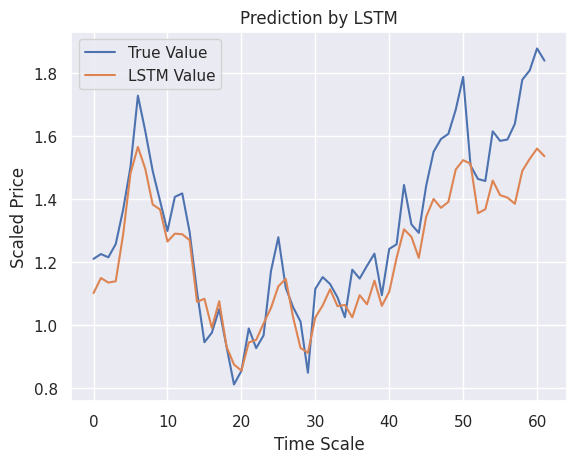

In [27]:
# Predicted vs True Price Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

In [28]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('RSME: ', rmse)
print('MAPE: ', mape)

RSME:  0.13230382
MAPE:  0.07446682
